In [2]:
import warnings
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy as np
import random
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Define the stock and time period
ticker = "VOO"
period = "1y"  # 1 year of data

# Pull data
df = yf.download(ticker, period=period)

# Calculate Moving Averages (75-day)
df['EMA_75'] = df['Close'].ewm(span=100, adjust=False).mean()

# Calculate Price Returns (Daily Percentage Change)
df['Price_Return'] = df['Close'].pct_change() * 100

df = df[['Close', 'Volume', 'EMA_75', 'Price_Return']]

# Drop NaN values (caused by moving average calculations)
df.dropna(inplace=True)
df.reset_index(inplace=True)

print(df.shape)
print(df)

# Define Labeling Function
def label(pr):
    # Label as 2 (Buy) if Price_Return > 1%
    # Label as 0 (Sell) if Price_Return < -1%
    # Otherwise, 1 (Hold)
    if pr > 1:  # This should work fine
        return 2
    elif pr < -1:
        return 0
    else:
        return 1

print(df.columns)
# Apply the label function correctly to each row
labels = []
for index, row in df.iterrows():
    # Extract the value as a single float
    pr = row['Price_Return']['']
    temp = label(pr)
    labels.append(temp)

df['Label'] = labels

print(df.head(3))  # Check the output

df = df[['Close', 'Volume', 'EMA_75', 'Price_Return', 'Label']]

# --- Standardize Data ---
X = df[['Close', 'Volume', 'EMA_75', 'Price_Return']].to_numpy()
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std  # Standardization

# Target variable
y = df['Label'].to_numpy()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

(250, 5)
Price        Date       Close   Volume      EMA_75 Price_Return
Ticker                    VOO      VOO                         
0      2024-05-15  480.460144  4399500  474.792178     1.218189
1      2024-05-16  479.542450  3347400  474.886243    -0.191003
2      2024-05-17  480.252960  3274000  474.992514     0.148164
3      2024-05-20  480.726593  2599600  475.106060     0.098622
4      2024-05-21  482.019257  2453600  475.242955     0.268898
..            ...         ...      ...         ...          ...
245    2025-05-08  519.340027  5088200  518.940592     0.666796
246    2025-05-09  518.650024  4739500  518.934838    -0.132861
247    2025-05-12  535.919983  7793600  519.271177     3.329790
248    2025-05-13  539.440002  7356800  519.670560     0.656818
249    2025-05-14  539.169983  4458218  520.056687    -0.050056

[250 rows x 5 columns]
MultiIndex([(        'Date',    ''),
            (       'Close', 'VOO'),
            (      'Volume', 'VOO'),
            (      'EMA_

running
Training set size: 448
Testing set size: 113
Label distribution: 2    187
1    187
0    187
Name: count, dtype: int64


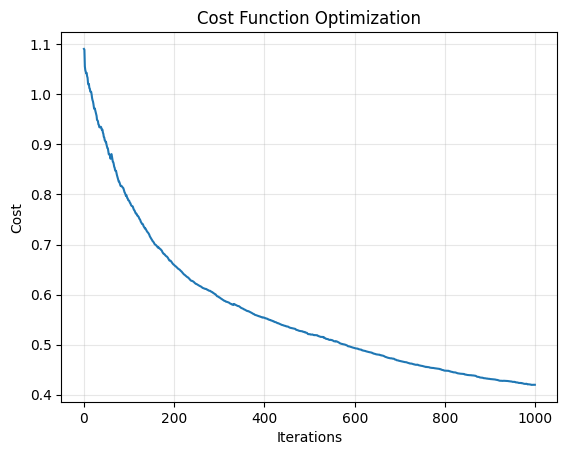

The logistic regression model parameters are: tensor([[-0.3024, -0.0892,  0.2205,  0.2465, -1.4573],
        [ 0.3702,  0.2638, -0.1867, -0.3001, -0.0533],
        [-0.0678, -0.1746, -0.0339,  0.0535,  1.5106]])


In [3]:
# --------------- Logistic Regression ----------------------------
class log_reg:
    def __init__(self, num_features, num_classes):
        self.W = torch.zeros((num_classes, num_features))
        
    def prob(self, sample):
        x, y = sample
        x = torch.tensor([1] + x.tolist(), dtype=torch.float32)  # Add bias term
        z = torch.matmul(self.W, x)
        return self.softmax(z)
        
    def softmax (self, z):
        z = z - torch.max(z)
        exp_z = torch.exp(z)
        return exp_z/exp_z.sum()

    def grad(self, sample):
        x, y = sample
        x = torch.tensor([1] + x.tolist(), dtype=torch.float32)
        probs = self.prob((x[1:],y))

        y_onehot = torch.zeros_like(probs)
        y_onehot[y] = 1.0
        grad_W = torch.outer(probs - y_onehot, x)
        return grad_W

    def grad_update(self, sample, eta=0.00001):
        g = self.grad(sample)
        self.W -= eta * g

    def display(self):
        print(f"The logistic regression model parameters are: {self.W}")
        
    def cal_prob(self, x):
        if len(x.shape) == 1:
            x = np.insert(x, 0, 1)  # Add bias term
            x = torch.tensor(x, dtype=torch.float32)
            z = torch.matmul(self.W, x)
            return self.softmax(z)
        else:
            batch = []
            for row in x:
                tow = np.insert(row,0,1)
                row = torch.tensor(row, dtype=torch.float32)
                z = torch.matmul(self.W, row)
                prob_prob = self.softmax(z)
                batch.append(prob_prob)
            return torch.stack(batch)


print("running")
# Standardize data
X = df[['Close', 'Volume', 'EMA_75', 'Price_Return']].to_numpy()
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std  # Standardization

# Target variable
y = df['Label'].to_numpy()
# ----------------- Splitting Data 80/20----------------
# Set a seed for reproducibility

# Apply SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Now split the resampled data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")


# Initialize model
model = log_reg(num_features=5, num_classes = 3)
rows = X_train.shape[0]
iterations = 1000
cost_history = []

# Training
for i in range(iterations):
    num = random.randint(0, rows - 1)
    sample = (X_train[num], y_train[num])
    model.grad_update(sample, eta=0.01)

    # Cost calculation
    cost = 0
    for j in range(len(X_train)):
        sample = (X_train[j], y_train[j])
        prob = model.prob(sample)

        y_onehot = torch.zeros(len(prob))
        y_onehot[y_train[j]] = 1.0

        # Compute cross-entropy loss
        cost += -torch.sum(y_onehot * torch.log(prob + 1e-9))
        
    cost /= len(X_train)
    cost_history.append(cost.item())
print(f"Label distribution: {pd.Series(y_resampled).value_counts()}")

# Plot cost over iterations
plt.plot(range(iterations), cost_history)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost Function Optimization')
plt.grid(alpha=0.3)
plt.show()

model.display()


Test Accuracy: 92.04%


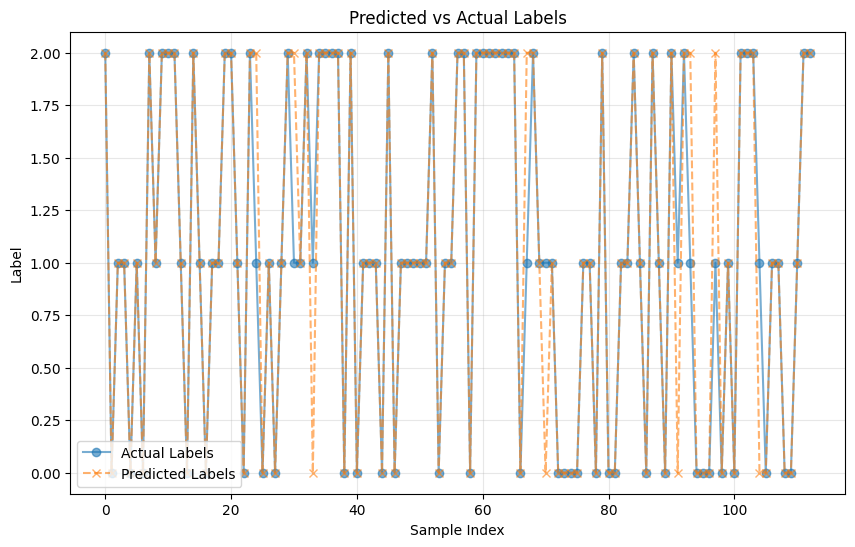

In [4]:
correct_predictions = 0
total_predictions = len(X_test)
pred_labels = []

for i in range(total_predictions):
    sample = X_test[i]
    probs = model.cal_prob(np.array(sample))  # Get the probability vector for the test sample

    # Determine the predicted label as the class with the highest probability
    pred_label = torch.argmax(probs).item()
    pred_labels.append(pred_label)

    # Check if the prediction is correct
    if pred_label == y_test[i]:
        correct_predictions += 1

# Calculate accuracy
accuracy = correct_predictions / total_predictions * 100
print(f"Test Accuracy: {accuracy:.2f}%")

# --- Plot Predictions vs Actual ---
plt.figure(figsize=(10, 6))
plt.plot(range(total_predictions), y_test, label='Actual Labels', marker='o', linestyle='-', alpha=0.6)
plt.plot(range(total_predictions), pred_labels, label='Predicted Labels', marker='x', linestyle='--', alpha=0.6)
plt.xlabel('Sample Index')
plt.ylabel('Label')
plt.title('Predicted vs Actual Labels')
plt.grid(alpha=0.3)
plt.legend()
plt.show()


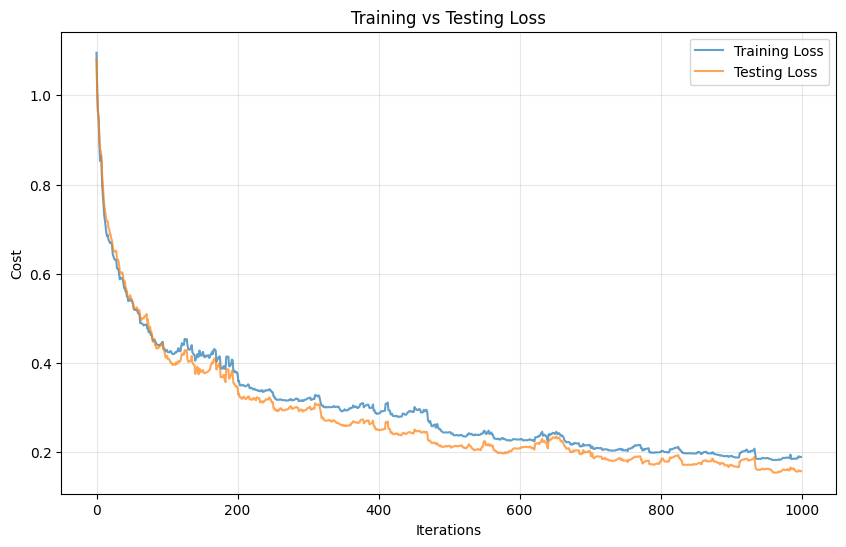

In [5]:
# Checking for Overfitting
# Initialize model
model = log_reg(num_features=5, num_classes=3)
rows = X_train.shape[0]
iterations = 1000
train_cost_history = []
test_cost_history = []

for i in range(iterations):
    # Random sample for stochastic gradient descent
    num = random.randint(0, rows - 1)
    sample = (X_train[num], y_train[num])
    model.grad_update(sample, eta=0.1)

    # Calculate training cost
    train_cost = 0
    for j in range(len(X_train)):
        sample = (X_train[j], y_train[j])
        prob = model.prob(sample)

        y_onehot = torch.zeros(len(prob))
        y_onehot[y_train[j]] = 1.0

        # Compute cross-entropy loss
        train_cost += -torch.sum(y_onehot * torch.log(prob + 1e-9))
        
    train_cost /= len(X_train)
    train_cost_history.append(train_cost.item())

    # Calculate testing cost
    test_cost = 0
    for j in range(len(X_test)):
        sample = (X_test[j], y_test[j])
        prob = model.prob(sample)

        y_onehot = torch.zeros(len(prob))
        y_onehot[y_test[j]] = 1.0

        test_cost += -torch.sum(y_onehot * torch.log(prob + 1e-9))

    test_cost /= len(X_test)
    test_cost_history.append(test_cost.item())

# Plot cost over iterations
plt.figure(figsize=(10, 6))
plt.plot(range(iterations), train_cost_history, label='Training Loss', alpha=0.7)
plt.plot(range(iterations), test_cost_history, label='Testing Loss', alpha=0.7)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Training vs Testing Loss')
plt.grid(alpha=0.3)
plt.legend()
plt.show()
